In [1]:
import numpy as np
import MigPreFuncoes
from scipy.fft import fft,rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib
import SlantStack
from tqdm import tqdm

Imported SlantStack_v2


In [2]:
importlib.reload(MigPreFuncoes)
importlib.reload(SlantStack)

Imported SlantStack_v2


<module 'SlantStack' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\SlantStack.py'>

In [47]:
def sigmoid(x):
    k = 4
    s = (1 / (1 + np.exp(-k*x)))
    return s

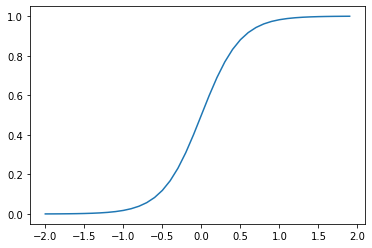

In [48]:
t = np.arange(-2,2,0.1)
s = sigmoid(t)

plt.plot(t,s)
plt.show()

In [ ]:
#tenho uma matriz com vários valores
#tenho que passar esse "filtro" da sigmoide
#multiplico cada valor pela sigmoide? só multiplicar tudo ele entende?
#vou ter que deslocar o 0 para o ponto que acho necessário pra cada caso, vai ter que ser uma variável 
   #entrada da função. 

### Teste para paralelizar o código

In [ ]:
#Numba não funciona com todas as funções do numpy, dá erro!

In [ ]:
import numba as nb
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
nz = 100
nx = 110
mig = np.ones([nz,nx])
a = []

for num in range(10):
    start_time = time.time()
    for x in range(nx):
        for z in range(nz):
            mig[z,x] = np.sqrt(z)+np.sqrt(x)
    print(f"{num} iteration:")
    ts = ((time.time() - start_time))
    print("--- %s seconds ---" % (ts))
    a.append(ts)
          
print(f"\n\n\nmean time of running = {np.mean(a)}")
    
#print("\n\n\n--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#parallelize?
import os
os.environ["OMP_NUM_THREADS"] = "8" 

In [ ]:
nz = 100
nx = 110
mig = np.ones([nz,nx])
a = []

for num in range(10):
    start_time = time.time()
    for x in range(nx):
        for z in range(nz):
            mig[z,x] = np.sqrt(z)+np.sqrt(x)
    print(f"{num} iteration:")
    ts = ((time.time() - start_time))
    print("--- %s seconds ---" % (ts))
    a.append(ts)
          
print(f"\n\n\nmean time of running = {np.mean(a)}")

In [ ]:
import numpy as np

nz = 100
nx = 110
mig = np.ones([nz,nx])

start_time = time.time()

for x in range(nx):
    for z in range(nz):
        mig[z,x] = np.sqrt(z)+np.sqrt(x)
    
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
@nb.njit(parallel=True)
def compute_mig(nz, nx, mig):
    for x in nb.prange(nx):
        for z in range(nz):
            mig[z,x] = np.sqrt(z)+np.sqrt(x)
    return mig

In [ ]:
nx=110
nz=100

mig=np.ones([nz,nx])

start_time = time.time()

mig = compute_mig(nz, nx, mig)

print("--- %s seconds ---" % (time.time() - start_time))

plt.imshow(mig)
plt.show()

In [ ]:
import numba as nb
import numpy as np

@nb.njit(nopython=True,parallel=True)
def parallel_code(isx, nz, nx, ntr, nt, nn, gather, timer, mig):
    for igx in nb.prange(ntr):
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx]
        t2 = (t<nt)*t
        trace1=gather.T[igx, t2.flatten().astype(np.int32)].reshape(nz, nx)
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
    return mig

isx=50
nz=100
nx=ntr=110
nt=298

nn = np.random.rand(nz,nx)
gather = np.ones([nz,nx])
timer = np.ones([nx,nz,nx])
mig = np.ones([nz,nx])
mig = mig+(nn-0.5)*0.2
gather = np.ascontiguousarray(gather)

In [ ]:
m = parallel_code(isx, nz, nx, ntr, nt, nn, gather, timer, mig)

In [ ]:
isx=50
nz=100
nx=ntr=110

nn = np.random.rand(nz,nx)
gather = np.ones([nz,nx])
timer = np.ones([nx,nz,nx])
mig = np.ones([nz,nx])
mig = mig+(nn-0.5)*0.2

for igx in range(ntr):
    t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx]
    t = (t<nt)*t
    trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))]
    trace1=trace1.reshape([nz,nx])
    mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1

In [ ]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=110
nz=100
dt=.005
dx=10  #meters
dz=10  #meters
c=1992 #velocidade m/s

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

plt.figure(figsize=(5,4))
plt.plot(W[280:340], "k", linewidth=0.9, alpha=0.8)
plt.title("Wavelet Utilizada nas Modelagens (Ricker)")
plt.ylabel("Amplitude")
plt.xlabel("Tempo (s)")
plt.show()

In [ ]:
velvector1 = np.loadtxt("Data/velvector") # Modelo de velocidade - 1 coluna em ASCII
vel = np.reshape(velvector1,[201,501]) # Coloca na dimensão correta
vel1 = vel[40:140,250:360] # Recorta um pequeno pedaço do modelovel[40:140,250:360]

c=vel1.min()

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
SW = 1./vel1 # Modelo de vagarosidade

In [ ]:
plt.imshow(vel1,extent=[0,nx*dx,dz*nz,0],aspect="auto")
plt.colorbar()
plt.title("Modelo de Velocidade Heterogêneo")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()

In [ ]:
plt.imshow(vel)

In [ ]:
SW = 1./vel[39:139,249:359]

dvel1=(np.abs(np.diff(vel1,axis=0)));
mx=np.max(dvel1.flatten('F'));  # Compute Refl Model for vel1;
dvel1=dvel1/mx;
dvel1=np.round(dvel1);
dvv=dvel1[nz-2,:]
R=np.append(dvel1,dvv[np.newaxis],axis=0);   # We lost a row in R by diff() so we add it back again

#Adicionando ruído no modelo
nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.2

plt.imshow(R, extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.title("Modelo de Reflectividade")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.colorbar()
plt.show()

In [ ]:
with open("Data/CSG/raiosVelvector.npy", 'rb') as f:
    TTh = np.load(f)

In [ ]:
TSX = (TTh[60,:,:])  # Traveltime 

timer=np.round(TTh/dt)+1

plt.imshow(TSX,extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.title("Tabela do Tempo de Trânsito")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.colorbar()
plt.show()

In [ ]:
dsx = 1
nsx = nx
ngx = nx

files = []

for i in range(0,nsx,dsx):
    filename = "Data/CSG/velvector_gather_shot_{}".format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [ ]:
shot = 60
filename = 'Data/CSG/velvector_gather_shot_{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1t = np.load(file)

print(nt)
gather1=gather1t[0:nt,:]
isx=shot

In [ ]:
def migvsp(timer,isx,dt,gather):
    [nt,ntr]=gather.shape
    [ntr2,nz,nx]=timer.shape
    if ntr!=ntr2:
        print('Gather e traveltime table tem numero diferente de traços')
    mig=np.zeros([nz,nx])
    for igx in tqdm(range(0,ntr)):
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx]
        t2 = (t<nt)*t
        trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))]
        trace1=trace1.reshape([nz,nx])#*w
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
    return mig

In [ ]:
start_time = time.time()

mig = migvsp(timer,isx,dt,gather1)  

print("--- %s seconds ---" % (time.time() - start_time))

plt.imshow(mig)
plt.show()

In [ ]:
@nb.njit(nopython=True,parallel=True)
def fast_migvsp(timer,isx,dt,gather,mig):
    [nt,ntr]=gather.shape
    [ntr2,nz,nx]=timer.shape
    if ntr!=ntr2:
        print('Gather e traveltime table tem numero diferente de traços')
    
    for igx in nb.prange(ntr):
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx]
        t2 = (t<nt)*t
        trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))]
        trace1=trace1.reshape([nz,nx])#*w
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
    return mig

In [ ]:
mig=np.zeros([nz,nx])

start_time = time.time()

mig = fast_migvsp(timer,isx,dt,gather1,mig)  

print("--- %s seconds ---" % (time.time() - start_time))

plt.imshow(mig)
plt.show()

In [ ]:
# Definindo a migvsp com phase shift, fator obliquidade,  
# abertura e janela.

def migvsp(timer,isx,dt,gather):
    [nt,ntr]=gather.shape
    [ntr2,nz,nx]=timer.shape
    if ntr!=ntr2:
        print('Gather e traveltime table tem numero diferente de traços')
    mig=np.zeros([nz,nx])
    # Loop over each trace of the shot gather at src isx
    for igx in tqdm(range(0,ntr)):
        #w = peso(igx,isx)
        t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx]
        t2 = (t<nt)*t #Check how to avoid this... summing amplitudes for t>nt
        trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))]
        trace1=trace1.reshape([nz,nx])#*w
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace1
        
    
    return mig

In [ ]:
# Migração de todos os gathers
# considerando peso w=1
# para posterior construção do dip field.

def kirchhoff_migration_stack(files,dx,dz,dt,win,dwin,app,TTh):
        
    """
    Calcula a migração para vários arquivos (todos os tiros ao longo de uma linha sísmica) com janela (window) e abertura (aperture)
    Stack das imagens migradas de cada tiro
    Considera a função peso w = 1
    
    Entrada:
    files - lista (array) com os dados sísmicos. 
    isx - posição do tiro
    dx - discretização no eixo x (m)
    dz - discretização no eixo z (m)
    dt - discretização do tempo (s)
    win - (tamanho da janela)/2
    dwin - passo da janela. Preferencialmente, dwin=dt
    app - tamanho da abertura
    TTh - tabela do tempo de trânsito calculada com a função raymodel3
    X - componente X do modelo; X = np.sin(m_theta); X.shape = [nz,nx]
    Y - componente Y do modelo; Y = np.cos(m_theta); Y.shape = [nz,nx]
    
    Saída:
    mig - imagem migrada com janela e abertura. Formato: matriz [nt,ntr]
    """

    gathers_shifted = []

    for i in files:
        gather_shifted = MigPreFuncoes.phase_shift(i)
        gathers_shifted.append(gather_shifted)

    files = gathers_shifted
    
    timer=np.round(TTh/dt)+1
    migs = []
        
    for count,gather in tqdm(enumerate(files)):
        isx = count
        window = np.arange(-win,win,dwin)
        [nt,ntr]=gather.shape
        [ntr2,nz,nx]=timer.shape
        if ntr!=ntr2:
            print('Gather e traveltime table tem numero diferente de traços')

        mig=np.zeros([nz,nx])
        mig_final=np.zeros([nz,nx])

        IX = np.arange(0,nx*dx,dx)
        IZ = np.arange(0,nz*dz,dz)
        [IIX,IIZ] = np.meshgrid(IX,IZ)
        # Loop over each trace of the shot gather at src isx
        for igx in range(0,ntr):
            #w = peso(TTh,dt,X,Y,igx,isx)
            w = 1
            trace_win = np.zeros([nz,nx])
            R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
            r_mask = (R==0)
            R[r_mask]= dx/1000
            obli = IIZ/R
            trace_app = MigPreFuncoes.taper(ntr,nz,app,isx,igx) 

            for j in range(len(window)):
                t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
                twin = t + window[j]
                t2 = (twin<nt)*twin 
                trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
                trace1 = trace1.reshape([nz,nx])*w #seção? imshow em um separado
                trace1 = trace1*trace_app
                trace_win = trace_win+trace1

            mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace_win*obli
        
        migs.append(mig)
    
    mig_final = np.add.reduce(migs)
        
    return mig_final

In [ ]:
win=20*dt #(metade) janela em tempo em cada etapa
dwin=dt
app=20 # abertura em traços

In [ ]:
migrated_image = kirchhoff_migration_stack(files,dx,dz,dt,win,dwin,app,TTh)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(migrated_image, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

## Local slant stack - calculando o dip field a partir da imagem migrada

In [ ]:
pmin = -2
pmax = 2
dp = 0.1
xwin=zwin=30
x_ini=z_ini=0

pm,sm = SlantStack.local_window(migrated_image,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp)

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Ângulos pmax (em tangente)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(pm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Semblance")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(sm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
m_theta = np.arctan(pm)

X = np.sin(m_theta)
Y = np.cos(m_theta)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
win=20*dt #(metade) janela em tempo em cada etapa
dwin=dt
app=20 # abertura em traços
epsilon=0.1  # frequency dependent

shot = 60
filename = 'Data/CSG/velvector_gather_shot_{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1t = np.load(file)

print(nt)
gather1=gather1t[0:nt,:]
isx=shot

In [ ]:
mig_winapp = MigPreFuncoes.migvsp_winapp(gather1,isx,dx,dz,dt,
                                         win,dwin,app,TTh,X,Y,epsilon)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_winapp, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
mig_diff = MigPreFuncoes.migvsp_winapp_diff(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Difração")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
mig_stack = MigPreFuncoes.migstack_winapp(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
mig_stack_diff = MigPreFuncoes.migstack_winapp_diff(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack_diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
def migvsp_winapp(gather,isx,dx,dz,dt,win,dwin,app,TTh):
    """
    Calcula a migração para 1 arquivo (1 tiro) com janela (window) e abertura (aperture)
    Considera a função peso w = w(s,r,t)
    
    Entrada:
    gather - dado sísmico (nt,ntr)
    isx - posição do tiro
    dx - discretização no eixo x (m)
    dz - discretização no eixo z (m)
    dt - discretização do tempo (s)
    win - (tamanho da janela)/2
    dwin - passo da janela. Preferencialmente, dwin=dt
    app - tamanho da abertura
    TTh - tabela do tempo de trânsito calculada com a função raymodel3
    X - componente X da normal do modelo; X = np.sin(m_theta); X.shape = [nz,nx]
    Y - componente Y da normal do modelo; Y = np.cos(m_theta); Y.shape = [nz,nx]
    epsilon - entre 0 e 1- relacionado à frequência (zona de Fresnel)
    Saída:
    mig - imagem migrada com janela e abertura. Formato: matriz [nt,ntr]
    """
    gather = MigPreFuncoes.phase_shift(gather)
    
    timer=np.round(TTh/dt)+1
    #timer=TTh
    
    window = np.arange(-win,win,dwin)
    [nt,ntr]=gather.shape
    [ntr2,nz,nx]=timer.shape
    if ntr!=ntr2:
        print('Gather e traveltime table tem numero diferente de traços')
        
    mig=np.zeros([nz,nx])
    
    IX = np.arange(0,nx*dx,dx)
    IZ = np.arange(0,nz*dz,dz)
    [IIX,IIZ] = np.meshgrid(IX,IZ)
    # Loop over each trace of the shot gather at src isx
    for igx in tqdm(range(0,ntr)):
        #w = peso(TTh,dt,X,Y,igx,isx)
        w=1
        #mask = w>(1-epsilon)
        trace_win = np.zeros([nz,nx])
        R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
        r_mask = (R==0)
        R[r_mask]= dx/1000 #trocando 0 por algo pequeno
        obli = IIZ/R
        trace_app = MigPreFuncoes.taper(ntr,nz,app,isx,igx) 
        
        for j in range(len(window)): #somar amplitudes da curva de difração com uma janela 
            t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
            twin = t + window[j]
            t2 = (twin<nt)*twin 
            trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
            trace1 = trace1.reshape([nz,nx])*(w) 
            trace1 = trace1*trace_app
            trace_win = trace_win+trace1
        
        mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace_win*obli
        
    return mig

In [ ]:
# TESTANDO OS PARÂMETROS - ABERTURA E JANELA

#win=25*dt #(metade) janela em tempo em cada etapa
dwin=dt
#app=40 # abertura em traços

shot = 60
filename = 'Data/CSG/velvector_gather_shot_{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1t = np.load(file)

gather1=gather1t[0:nt,:]
isx=shot

for win in range(10,80,5):
    for app in range(10,80,5):
        migrated_image = MigPreFuncoes.migvsp_dipfield(gather1,isx,dx,dz,dt,win*dt,dwin,app,TTh)
        print(f"App = {app} ; Win = {win}")
        plt.imshow(migrated_image, aspect="auto",extent=[0,dx*nx,dz*nz,0])
        plt.show()

In [ ]:
nx = 40
ny = 60
dummy_matrix = np.ones([ny,nx])

for i in range(dummy_matrix.shape[0]):
    for j in range(dummy_matrix.shape[1]):
        dummy_matrix[i,j] = (i+j)

#Coordenadas de um determinado ponto imagem
x0 = np.round(nx/2)
y0 = np.round(ny/2)

x = np.arange(nx)

#Variando a inclinação da reta
pini = -5
pfim = 5
dp = 0.1
p = np.arange(pini,pfim,dp)

plt.imshow(dummy_matrix,aspect="auto")
plt.plot(x0,y0,"ro")

for i in range(len(p)):
    y = p[i]*(x-x0) + y0
    
    for k in range(nx):
        if (x[k]<nx) and (y[k]>0 and y[k]<ny):
            plt.plot(x[k],y[k],"k.")

    plt.plot(x,y)

plt.xlim(0,nx)
plt.ylim(0,ny)
plt.show()

In [ ]:
files = np.array(files)
files.ndim

gather1 = np.array(gather)
gather1.ndim

In [ ]:
refl,diff = MigPreFuncoes.kirchhoffMigration(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
def kirchhoffMigration(gather,isx,dx,dz,dt,win,dwin,app,TTh,X,Y):
    """
    Calcula a migração para 1 arquivo (1 tiro) com janela (window) e abertura (aperture)
    Considera a função peso w = w(s,r,t)
    
    Entrada:
    gather - dado sísmico (nt,ntr) ou lista com dados sísmicos (nt,ntr,?)
    isx - posição do tiro
    dx - discretização no eixo x (m)
    dz - discretização no eixo z (m)
    dt - discretização do tempo (s)
    win - (tamanho da janela)/2
    dwin - passo da janela. Preferencialmente, dwin=dt
    app - tamanho da abertura
    TTh - tabela do tempo de trânsito calculada com a função raymodel3
    X - componente X da normal do modelo; X = np.sin(m_theta); X.shape = [nz,nx]
    Y - componente Y da normal do modelo; Y = np.cos(m_theta); Y.shape = [nz,nx]
    epsilon - entre 0 e 1- relacionado à frequência (zona de Fresnel)
    
    Saída:
    mig - imagem migrada com janela e abertura. Formato: matriz [nt,ntr]
    """
    
    gather = np.array(gather)
    
    # single shot 
    if gather.ndim == 2:
    
        gather = phase_shift(gather)
        timer=np.round(TTh/dt)+1

        window = np.arange(-win,win,dwin)
        [nt,ntr]=gather.shape
        [ntr2,nz,nx]=timer.shape
        if ntr!=ntr2:
            print('Gather e traveltime table tem numero diferente de traços')

        refl_migimage=np.zeros([nz,nx])
        diff_migimage=np.zeros([nz,nx])

        IX = np.arange(0,nx*dx,dx)
        IZ = np.arange(0,nz*dz,dz)
        [IIX,IIZ] = np.meshgrid(IX,IZ)

        for igx in tqdm(range(0,ntr)):
            w = peso(TTh,dt,X,Y,igx,isx)
            trace_win = np.zeros([nz,nx])
            R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
            r_mask = (R==0)
            R[r_mask]= dx/1000 
            obli = IIZ/R
            trace_app = taper(ntr,nz,app,isx,igx) 

            for j in range(len(window)):
                t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] 
                twin = t + window[j]
                t2 = (twin<nt)*twin 
                trace1 = gather.T[np.ix_([igx],t2.flatten().astype(np.int32))]
                trace_refl1 = trace1.reshape([nz,nx])*(w)
                trace_diff1 = trace1.reshape([nz,nx])*(1-w)
                trace_refl = trace_refl1*trace_app
                trace_diff = trace_diff1*trace_app
                trace_reflwin = trace_reflwin+trace_refl
                trace_diffwin = trace_diffwin+trace_diff

            refl_migimage[0:nz,0:nx] = refl_migimage[0:nz,0:nx] + trace_reflwin*obli
            diff_migimage[0:nz,0:nx] = refl_migimage[0:nz,0:nx] + trace_diffwin*obli
    
    # multiple shots, stack the migrated images
    elif gather.ndim == 3:
        
        gathers_shifted = []

        for i in gather:
            gather_shifted = phase_shift(i)
            gathers_shifted.append(gather_shifted)

        files = gathers_shifted
        timer=np.round(TTh/dt)+1

        refl_migimages = []
        diff_migimages = []
        
        refl_migimage = np.zeros([nz,nx])
        diff_migimage = np.zeros([nz,nx])
        

        for count,gather in tqdm(enumerate(files)):
            isx = count
            window = np.arange(-win,win,dwin)
            [nt,ntr]=gather.shape
            [ntr2,nz,nx]=timer.shape
            if ntr!=ntr2:
                print('Gather e traveltime table tem numero diferente de traços')

            #mig=np.zeros([nz,nx])
            refl_mig = np.zeros([nz,nx])
            diff_mig = np.zeros([nz,nx])
            
            IX = np.arange(0,nx*dx,dx)
            IZ = np.arange(0,nz*dz,dz)
            [IIX,IIZ] = np.meshgrid(IX,IZ)

            for igx in range(0,ntr):
                w = peso(TTh,dt,X,Y,igx,isx)
                trace_win = np.zeros([nz,nx])
                R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
                r_mask = (R==0)
                R[r_mask]= dx/1000
                obli = IIZ/R
                trace_app = taper(ntr,nz,app,isx,igx) 

                for j in range(len(window)):
                    t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] 
                    twin = t + window[j]
                    t2 = (twin<nt)*twin 
                    trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
                    trace1 = trace1.reshape([nz,nx])*(1-w) 
                    #trace1 = trace1*trace_app
                    #trace_win = trace_win+trace1
                    trace_refl1 = trace1.reshape([nz,nx])*(w)
                    trace_diff1 = trace1.reshape([nz,nx])*(1-w)
                    trace_refl = trace_refl1*trace_app
                    trace_diff = trace_diff1*trace_app
                    trace_reflwin = trace_reflwin+trace_refl
                    trace_diffwin = trace_diffwin+trace_diff

                refl_mig[0:nz,0:nx] = refl_mig[0:nz,0:nx] + trace_reflwin*obli
                diff_mig[0:nz,0:nx] = diff_mig[0:nz,0:nx] + trace_diffwin*obli

            #migs.append(mig)
            refl_migimages.append(refl_mig)
            diff_migimages.append(diff_mig)

        #mig_final = np.add.reduce(migs)
        refl_migimage = np.add.reduce(refl_migimages)
        diff_migimage = np.add.reduce(diff_migimages)
        
    return refl_migimage, diff_migimage

In [ ]:
def migvsp_double(gather,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon):
    
    gather = np.array(gather)
    
    if gather.ndim == 2:
    
        gather = MigPreFuncoes.phase_shift(gather)

        timer=np.round(TTh/dt)+1
        #timer=TTh

        window = np.arange(-win,win,dwin)
        [nt,ntr]=gather.shape
        [ntr2,nz,nx]=timer.shape
        if ntr!=ntr2:
            print('Gather e traveltime table tem numero diferente de traços')

        #mig=np.zeros([nz,nx])
        refl_mig = np.zeros([nz,nx])
        diff_mig = np.zeros([nz,nx])

        IX = np.arange(0,nx*dx,dx)
        IZ = np.arange(0,nz*dz,dz)
        [IIX,IIZ] = np.meshgrid(IX,IZ)
        # Loop over each trace of the shot gather at src isx
        for igx in tqdm(range(0,ntr)):
            w = MigPreFuncoes.peso(TTh,dt,X,Y,igx,isx)
            #trace_win = np.zeros([nz,nx])
            trace_reflwin = np.zeros([nz,nx])
            trace_diffwin = np.zeros([nz,nx])
            R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
            r_mask = (R==0)
            R[r_mask]= dx/1000 #trocando 0 por algo pequeno
            obli = IIZ/R
            trace_app = MigPreFuncoes.taper(ntr,nz,app,isx,igx) 

            for j in range(len(window)): #somar amplitudes da curva de difração com uma janela 
                t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
                twin = t + window[j]
                t2 = (twin<nt)*twin 
                trace1=gather.T[np.ix_([igx],t2.flatten().astype(np.int32))] 
                #trace1 = trace1.reshape([nz,nx])*(w)
                trace_refl1 = trace1.reshape([nz,nx])*(w)
                trace_diff1 = trace1.reshape([nz,nx])*(1-w)
                #trace1 = trace1*trace_app
                trace_refl = trace_refl1*trace_app
                trace_diff = trace_diff1*trace_app
                #trace_win = trace_win+trace1
                trace_reflwin = trace_reflwin + trace_refl
                trace_diffwin = trace_diffwin + trace_diff

            #mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace_reflwin*obli
            refl_mig[0:nz,0:nx] = refl_mig[0:nz,0:nx] + trace_reflwin*obli
            diff_mig[0:nz,0:nx] = diff_mig[0:nz,0:nx] + trace_diffwin*obli
            
    elif gather.ndim == 3:

        gathers_shifted = []

        for i in gather:
            gather_shifted = MigPreFuncoes.phase_shift(i)
            gathers_shifted.append(gather_shifted)

        files = gathers_shifted
        timer=np.round(TTh/dt)+1
        
        #migs = []
        refl_migs = []
        diff_migs = []

        for count,gather in tqdm(enumerate(files)):
            isx = count
            window = np.arange(-win,win,dwin)
            [nt,ntr] = gather.shape
            [ntr2,nz,nx] = timer.shape
            if ntr!=ntr2:
                print('Gather e traveltime table tem numero diferente de traços')

            #mig=np.zeros([nz,nx])
            #mig_final=np.zeros([nz,nx])
            
            refl_mig_isx = np.zeros([nz,nx])
            diff_mig_isx = np.zeros([nz,nx])

            IX = np.arange(0,nx*dx,dx)
            IZ = np.arange(0,nz*dz,dz)
            [IIX,IIZ] = np.meshgrid(IX,IZ)

            for igx in range(0,ntr):
                w = MigPreFuncoes.peso(TTh,dt,X,Y,igx,isx)
                #trace_win = np.zeros([nz,nx])
                trace_reflwin = np.zeros([nz,nx])
                trace_diffwin = np.zeros([nz,nx])
                R = np.sqrt(IIZ**2 + (IIX-(igx+isx)/2*dx)**2)
                r_mask = (R==0)
                R[r_mask]= dx/1000
                obli = IIZ/R
                trace_app = MigPreFuncoes.taper(ntr,nz,app,isx,igx) 

                for j in range(len(window)):
                    t = timer[isx,0:nz,0:nx] + timer[igx,0:nz,0:nx] #t_{d}
                    twin = t + window[j]
                    t2 = (twin<nt)*twin 
                    trace1 = gather.T[np.ix_([igx],t2.flatten().astype(np.int32))]
                    #trace1 = trace1.reshape([nz,nx])*w 
                    trace_refl1 = trace1.reshape([nz,nx])*(w)
                    trace_diff1 = trace1.reshape([nz,nx])*(1-w)
                    #trace1 = trace1*trace_app
                    trace_refl = trace_refl1*trace_app
                    trace_diff = trace_diff1*trace_app
                    #trace_win = trace_win+trace1
                    trace_reflwin = trace_reflwin + trace_refl
                    trace_diffwin = trace_diffwin + trace_diff

                #mig[0:nz,0:nx]=mig[0:nz,0:nx] + trace_win*obli
                refl_mig_isx[0:nz,0:nx] = refl_mig_isx[0:nz,0:nx] + trace_reflwin*obli
                diff_mig_isx[0:nz,0:nx] = diff_mig_isx[0:nz,0:nx] + trace_diffwin*obli

            #migs.append(mig)
            refl_migs.append(refl_mig_isx)
            diff_migs.append(diff_mig_isx)

        #mig_final = np.add.reduce(migs)
        refl_mig = np.add.reduce(refl_migs)
        diff_mig = np.add.reduce(diff_migs)
        
    return refl_mig,diff_mig

In [ ]:
M = MigPreFuncoes.migvsp_winapp(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

plt.imshow(M,aspect="auto")
plt.show()

In [ ]:
D = MigPreFuncoes.migvsp_winapp_diff(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

plt.imshow(D,aspect="auto")
plt.show()

In [ ]:
Refl, Diff = migvsp_double(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

plt.imshow(Refl,aspect="auto")
plt.show()

plt.imshow(Diff,aspect="auto")
plt.show()

In [ ]:
Refl, Diff = migvsp_double(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

plt.imshow(Refl,aspect="auto")
plt.show()

plt.imshow(Diff,aspect="auto")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def rr(nps, fr, dt):
    npt = nps * dt
    t = np.arange(-npt/2, npt/2, dt)
    rr = (1 - t**2 * fr**2 * np.pi**2) * np.exp(-t**2 * np.pi**2 * fr**2)
    return rr[:nps]

def ricker(nps,fr,dt):
    npt = nps * dt
    t = np.arange(-npt/2,npt/2,dt)
    rick1=(1-t *t * fr**2 *np.pi**2  ) * np.exp(- t**2 * np.pi**2 * fr**2 )
    rick=rick1[int(np.round(nps/2))-(int(np.round(1/fr/dt)))+1:nps]
    l = len(rick)
    if l<nps:
        rick2=np.append(rick,np.zeros([1,nps-1]))
    l=nps
    rick=rick2
    return np.array(rick)

In [ ]:
fr=40 
nps=200 
dt=.004 
dx=dz=1
nx=110
nz=100
c=250

rick1=ricker(nps,fr,dt)

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick1[0:nps-1]


plt.plot(np.arange(-nt*dt,nt*dt,dt),W)
plt.show()

rick2=rr(nps,fr,dt)

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
W2=np.zeros(2*nt);
W2[nt:nt+nps-1]=rick2[0:nps-1]

plt.plot(np.arange(-nt*dt,nt*dt,dt),W2)
plt.show()

In [ ]:
ricker(51, 25, 0.004)

In [ ]:
def lineseg2(z0,x0,z1,x1):
    z1=z1+1
    x1=x1+1
    dz = (z1-z0)
    dx = (x1-x0)
    sgnz = np.sign(dz)
    sgnx = np.sign(dx)
    pz=[]
    px=[]
    pz.append(z0)
    px.append(x0)
    j = 2
    if sgnz!=0:
        zrange = np.arange(z0+sgnz,z1,sgnz)
        for z in zrange:
            pz.append(z)
            px.append(x0 + (z-z0)*dx/dz)
            j = j+1
    if sgnx!=0:
        xrange = np.arange(x0+sgnx,x1,sgnx)
        for x in xrange:
            px.append(x)
            pz.append(z0+(x-x0)*dz/dx)
            j = j+1
            
            
    pz.append(z1)
    px.append(x1)
    px = np.sort(px)
    pz = np.sort(pz)
    if  sgnx==-sgnz:
        px=np.flip(px)
    return [pz,px,j]

In [ ]:
lineseg2(0, 0, 3, 3)